In [1]:
# https://colab.research.google.com/github/vsitzmann/siren/blob/master/explore_siren.ipynb

In [2]:
!pip install -U scikit-image
!pip install -U miplib
!pip install -U emda # Useless, uninstall later

Requirement already up-to-date: scikit-image in ./miniconda3/envs/thesis/lib/python3.7/site-packages (0.18.1)
Requirement already up-to-date: miplib in ./miniconda3/envs/thesis/lib/python3.7/site-packages (1.0.6)
Requirement already up-to-date: emda in ./miniconda3/envs/thesis/lib/python3.7/site-packages (1.1.3.post3)


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, ToPILImage
import numpy as np
import skimage
import matplotlib.pyplot as plt

import scipy

import time
import gc

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

!pip install gemmi
import gemmi

In [4]:
# https://github.com/sakoho81/miplib
# Install: https://pypi.org/project/miplib/

import miplib.analysis.resolution.fourier_ring_correlation as frc
import miplib.analysis.resolution.fourier_shell_correlation as fsc
from miplib.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import miplib.ui.plots.frc as frcplots
from miplib.ui.cli import miplib_entry_point_options as options
from miplib.data.containers.image import Image
import miplib.data.io.read as imread
import miplib.processing.image as imops

In [5]:
from inspect import getmembers, isfunction
getmembers(frc, isfunction)

[('batch_evaluate_frc',
  <function miplib.analysis.resolution.fourier_ring_correlation.batch_evaluate_frc>),
 ('calculate_single_image_frc',
  <function miplib.analysis.resolution.fourier_ring_correlation.calculate_single_image_frc>),
 ('calculate_single_image_sectioned_frc',
  <function miplib.analysis.resolution.fourier_ring_correlation.calculate_single_image_sectioned_frc>),
 ('calculate_two_image_frc',
  <function miplib.analysis.resolution.fourier_ring_correlation.calculate_two_image_frc>)]

In [6]:
getmembers(imread, isfunction)

[('__bioformats', <function miplib.data.io.read.__bioformats>),
 ('__itk_image', <function miplib.data.io.read.__itk_image>),
 ('__itk_transform', <function miplib.data.io.read.__itk_transform>),
 ('__tiff', <function miplib.data.io.read.__tiff>),
 ('get_image', <function miplib.data.io.read.get_image>)]

In [7]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [8]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

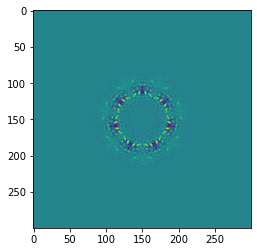

In [9]:
# Getting test T20S map
if not (os.path.exists('emd_6287.map.gz') or os.path.exists('emd_6287.map')):
    !wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-6287/map/emd_6287.map.gz
    !gunzip 'emd_6287.map.gz'
map_path = 'emd_6287.map'

# https://bioinformatics.stackexchange.com/questions/13079/ccp4-file-to-a-python-3-numpy-array-or-similar-workaround
test_map = gemmi.read_ccp4_map(map_path)
test_map.setup()  # optional

raw_structure = np.array(test_map.grid, copy=False)
plt.imshow(raw_structure[:, :, raw_structure.shape[0] // 2])

(100, 100, 100, 1)


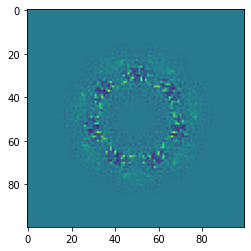

In [10]:
structure = np.expand_dims(raw_structure, axis=-1)
structure = structure[50:-50, 50:-50, 50:-50, :]
structure = scipy.ndimage.zoom(structure, (0.5, 0.5, 0.5, 1))

print(structure.shape)
# plt.imshow(structure[:, :, structure.shape[0] // 2])
plt.imshow(structure[:, :, structure.shape[0] // 2])

In [11]:
# Arguments
shell_size = 2
epsilon = 1e-7

In [15]:
original_image = structure
pred_image = np.random.normal(np.mean(structure), np.std(structure), (100, 100, 100))

In [16]:
# https://www.jeol.co.jp/en/words/emterms/search_result.html?keyword=Fourier%20Shell%20Correlation%2C%20FSC

# Calculations
F1 = np.fft.fftshift(np.fft.fft2(original_image.squeeze()))
F2 = np.fft.fftshift(np.fft.fft2(pred_image.squeeze()))

F1_abs_squared = np.square(np.abs(F1))
F2_abs_squared = np.square(np.abs(F2))
F2_conj = F2.conj()

n = original_image.squeeze().shape[0]
freq_interval = shell_size / n
freq_intervals = np.array([freq_idx * freq_interval for freq_idx in range(1, int(0.5 / freq_interval) + 1)])

shell_correlations = np.zeros_like(freq_intervals)
shell_F1_abs_squared = np.zeros_like(freq_intervals)
shell_F2_abs_squared = np.zeros_like(freq_intervals)

center_point = scipy.ndimage.measurements.center_of_mass(np.ones_like(original_image.squeeze()))
grid_z, grid_y, grid_x = np.mgrid[0:n, 0:n, 0:n]
grid_z = (grid_z - center_point[0]) / n
grid_y = (grid_y - center_point[1]) / n
grid_x = (grid_x - center_point[2]) / n
distances = np.linalg.norm(np.stack((grid_z, grid_y, grid_x), axis=0), axis=0)
distance_vals = np.unique(distances)
distance_vals = distance_vals[distance_vals < 0.5]
for spatial_freq in distance_vals:
    freq_idx = np.where(freq_intervals == freq_intervals[spatial_freq <= freq_intervals].min())[0][0]
    
    curr_F1 = F1[distances == spatial_freq]
    curr_F2_conj = F2_conj[distances == spatial_freq]
    curr_correlation = curr_F1 * curr_F2_conj
    shell_correlations[freq_idx] += np.sum(curr_correlation)
    shell_F1_abs_squared[freq_idx] += np.sum(F1_abs_squared[distances == spatial_freq])
    shell_F2_abs_squared[freq_idx] += np.sum(F2_abs_squared[distances == spatial_freq])
    
FSC_vals = shell_correlations / np.sqrt(shell_F1_abs_squared * shell_F2_abs_squared)

'''
# Calculations
original_image_fft = np.fft.fftshift(np.fft.fft2(original_image.squeeze()))
raw_amplitudes = np.abs(original_image_fft)

n = original_image.squeeze().shape[0]
freq_interval = shell_size / n
freq_intervals = np.array([freq_idx * freq_interval for freq_idx in range(1, int(0.5 / freq_interval) + 1)])
amplitudes = np.zeros_like(freq_intervals)
num_amplitudes = np.zeros_like(freq_intervals)

center_point = scipy.ndimage.measurements.center_of_mass(np.ones_like(original_image.squeeze()))
grid_y, grid_x = np.mgrid[0:output_dims, 0:output_dims]
grid_y = (grid_y - center_point[0]) / output_dims
grid_x = (grid_x - center_point[1]) / output_dims
distances = np.hypot(grid_x, grid_y)
distance_vals = np.unique(distances)
distance_vals = distance_vals[distance_vals < 0.5]
for spatial_freq in distance_vals:
    freq_idx = np.where(freq_intervals == freq_intervals[spatial_freq <= freq_intervals].min())[0][0]
    curr_amplitudes = raw_amplitudes[distances == spatial_freq]
    amplitudes[freq_idx] += np.sum(curr_amplitudes)
    num_amplitudes[freq_idx] += len(curr_amplitudes)
    
amplitudes /= num_amplitudes
'''

/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part


'\n# Calculations\noriginal_image_fft = np.fft.fftshift(np.fft.fft2(original_image.squeeze()))\nraw_amplitudes = np.abs(original_image_fft)\n\nn = original_image.squeeze().shape[0]\nfreq_interval = shell_size / n\nfreq_intervals = np.array([freq_idx * freq_interval for freq_idx in range(1, int(0.5 / freq_interval) + 1)])\namplitudes = np.zeros_like(freq_intervals)\nnum_amplitudes = np.zeros_like(freq_intervals)\n\ncenter_point = scipy.ndimage.measurements.center_of_mass(np.ones_like(original_image.squeeze()))\ngrid_y, grid_x = np.mgrid[0:output_dims, 0:output_dims]\ngrid_y = (grid_y - center_point[0]) / output_dims\ngrid_x = (grid_x - center_point[1]) / output_dims\ndistances = np.hypot(grid_x, grid_y)\ndistance_vals = np.unique(distances)\ndistance_vals = distance_vals[distance_vals < 0.5]\nfor spatial_freq in distance_vals:\n    freq_idx = np.where(freq_intervals == freq_intervals[spatial_freq <= freq_intervals].min())[0][0]\n    curr_amplitudes = raw_amplitudes[distances == spatial_

In [18]:
print(FSC_vals)

[-0.26058199 -0.1372861  -0.09503384 -0.085815   -0.04075986 -0.05363443
 -0.03692147 -0.02151201 -0.05210243 -0.04419508 -0.02822002  0.00208482
  0.00508692  0.02487163  0.01151463  0.02079523 -0.00135611  0.01118197
  0.01829291  0.01076271  0.0102333   0.0128445   0.00604852  0.011331
  0.00365787]


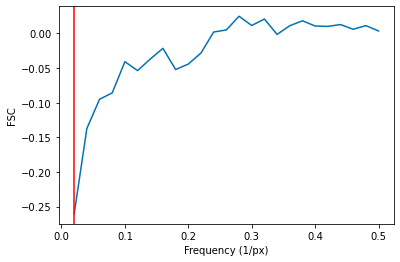

In [17]:
# Plotting
plt.plot(freq_intervals, FSC_vals)
negligible_threshold_check = np.where((FSC_vals < 0.5) == True)[0]
if len(negligible_threshold_check) > 0:
    plt.axvline(x=freq_intervals[negligible_threshold_check[0]], color='red')
plt.xlabel('Frequency (1/px)')
plt.ylabel('FSC')
plt.show()

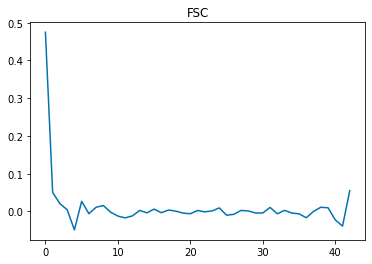

In [21]:
# Based on https://tttrlib.readthedocs.io/en/latest/auto_examples/imaging/plot_imaging_frc.html

# Arguments
shell_size = 2
epsilon = 1e-7

original_image = structure
pred_image = np.random.normal(np.mean(structure), np.std(structure), (100, 100, 100))

# Calculations
F1 = np.fft.fftn(original_image.squeeze() / np.sum(original_image), axes=(0,1,2))
F2 = np.fft.fftn(pred_image.squeeze() / np.sum(pred_image), axes=(0,1,2))

F1F2 = np.real(F1 * np.conj(F2))
F1_abs_squared = np.abs(F1)**2
F2_abs_squared = np.abs(F2)**2

nx, ny, nz = F1F2.shape
x = np.arange(-np.floor(nx / 2.0), np.ceil(nx / 2.0))
y = np.arange(-np.floor(ny / 2.0), np.ceil(ny / 2.0))
z = np.arange(-np.floor(nz / 2.0), np.ceil(nz / 2.0))

distances = []
numerators = []
F1_norms = []
F2_norms = []

for xi, yi, zi in np.array(np.meshgrid(x, y, z)).T.reshape(-1, 3):
    distances.append(np.sqrt((xi ** 2) + (yi ** 2) + (zi ** 2)))
    xi = int(xi)
    yi = int(yi)
    zi = int(zi)
    
    numerators.append(F1F2[xi, yi, zi])
    F1_norms.append(F1_abs_squared[xi, yi, zi])
    F2_norms.append(F2_abs_squared[xi, yi, zi])
    
bins = np.arange(0, np.sqrt(((nx // 2) ** 2) + ((ny // 2) ** 2) + ((nz // 2) ** 2)), shell_size)
F1F2_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=numerators
)
F1_norm_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=F1_norms
)
F2_norm_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=F2_norms
)

FSC_vals = F1F2_histogram / np.sqrt(F1_norm_histogram * F2_norm_histogram)

frequencies = np.linspace(0, 0.5, num=len(FSC_vals))
plt.plot(frequencies, FSC_vals)
negligible_threshold_check = np.where((FSC_vals < 0.5) == True)[0]
if len(negligible_threshold_check) > 0:
    resolution = frequencies[negligible_threshold_check[0]]
    plt.axvline(x=frequencies[negligible_threshold_check[0]], color='red')
    print("Resolution:", resolution)
plt.xlabel('Frequency (1/px)')
plt.ylabel('FSC')
plt.show()

In [12]:
import emda
getmembers(emda)

[('__builtins__',
  {'__name__': 'builtins',
   '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
   '__package__': '',
   '__loader__': _frozen_importlib.BuiltinImporter,
   '__spec__': ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>),
   '__build_class__': <function __build_class__>,
   '__import__': <function __import__>,
   'abs': <function abs>,
   'all': <function all>,
   'any': <function any>,
   'ascii': <function ascii>,
   'bin': <function bin>,
   'breakpoint': <function breakpoint>,
   'callable': <function callable>,
   'chr': <function chr>,
   'compile': <function compile>,
   'delattr': <function delattr>,
   'dir': <function dir>,
   'divmod': <function divmod>,
   'eval': <function eval>,
   'exec': <function exec>,
   'format': <function format>,
   'getattr': <function getattr>,
   'globals': <function globals>,
   'hasattr': <function hasattr

In [27]:
# https://www2.mrc-lmb.cam.ac.uk/groups/murshudov/content/emda/emda.html

original_image = structure
pred_image = structure


hf1 = np.fft.fftshift(np.fft.fftn(ar1))
hf2 = np.fft.fftshift(np.fft.fftn(resampled_ar2))
nbin, res_arr, bin_idx = restools.get_resolution_array(uc, hf1)
bin_fsc, covar  = fsc.anytwomaps_fsc_covariance(hf1,hf2,bin_idx,nbin)

In [13]:
# https://github.com/sakoho81/miplib/blob/10f14c8eccefcc0d90feea8dcea5b36a3801797b/miplib/processing/ndarray.py#L180
# From above

def safe_divide(numerator, denominator):
    with np.errstate(divide="ignore", invalid="ignore"):
        result = numerator / denominator
        result[result == np.inf] = 0.0
        return np.nan_to_num(result)
    
# https://github.com/sakoho81/miplib/blob/10f14c8eccefcc0d90feea8dcea5b36a3801797b/miplib/ui/plots/frc.py#L388
# Slightly altered from code above to fix labels and similar

def __make_frc_subplot(ax, frc, title):
    """
    Creates a plot of the FRC curves in the curve_list. Single or multiple vurves can
    be plotted.
    """

    # # Font setting
    # font0 = FontProperties()
    # font1 = font0.copy()
    # font1.set_size('medium')
    # font = font1.copy()
    # font.set_family('sans')
    # rc('text', usetex=True)

    # Enable grid
    gridLineWidth = 0.2
    # ax.yaxis.grid(True, linewidth=gridLineWidth, linestyle='-', color='0.05')

    # Axis labelling
    xlabel = 'Frequency (1/px)'
    ylabel = 'Correlation'
    # ax.set_xlabel(xlabel, fontsize=12, position=(0.5, -0.2))
    # ax.set_ylabel(ylabel, fontsize=12, position=(0.5, 0.5))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.set_ylim([0, 1.2])

    # Title
    ax.set_title(title)

    # Plot calculated FRC values as xy scatter.
    y = frc.correlation["correlation"]
    x = frc.correlation["frequency"]
    x_axis = safe_divide(x, 2 * frc.resolution["spacing"])

    ax.plot(x_axis, y, '^', markersize=6, color='#b5b5b3',
            label='FRC')

    # Plot polynomial fit as a line plot over the FRC scatter
    y = frc.correlation["curve-fit"]
    ax.plot(x_axis, y, linewidth=3, color='#61a2da',
            label='Least-squares fit')

    # Plot the resolution threshold curve
    y = frc.resolution["threshold"]
    res_crit = frc.resolution["criterion"]
    if res_crit == 'one-bit':
        label = 'One-bit curve'
    elif res_crit == 'half-bit':
        label = 'Half-bit curve'
    elif res_crit == 'fixed':
        label = 'y = %f' % y[0]
    else:
        label = "Threshold"

    if x[-1] < 1.0:
        x = np.append(x, 1.0)
        y = np.append(y, y[-1])

    x_axis = safe_divide(x, 2 * frc.resolution["spacing"])

    ax.plot(x_axis, y, color='#d77186',
            label=label, lw=2, linestyle='--')

    # Plot resolution point
    y0 = frc.resolution["resolution-point"][0]
    x0 = frc.resolution["resolution-point"][1] / (2 * frc.resolution["spacing"])

    ax.plot(x0, y0, 'ro', markersize=8, label='Resolution point', color='#D75725')

    verts = [(x0, 0), (x0, y0)]
    xs, ys = list(zip(*verts))

    ax.plot(xs, ys, 'x--', lw=3, color='#D75725', ms=10)
    # ax.text(x0, y0 + 0.10, 'RESOL-FREQ', fontsize=12)

    resolution = "The resolution is {} px.".format(
        frc.resolution["resolution"])
    ax.text(0.5, -0.3, resolution, ha="center", fontsize=12)

In [19]:
'''
args_list = ("None \
--bin-delta=1 \
--frc-curve-fit-type=smooth-spline \
--resolution-threshold-criterion=fixed \
--frc-mode=two-image \
--resolution-threshold-value=0.5 \
--resolution-snr-value=1").split()
'''

args_list = [None, '--bin-delta=10', '--resolution-threshold-criterion=snr', '--resolution-snr-value=0.5',
            '--angle-delta=15', '--enable-hollow-iterator', '--extract-angle-delta=.1', 
             '--resolution-point-sigma=0.01', '--frc-curve-fit-type=spline']
            
args = options.get_frc_script_options(args_list)

frc_results = FourierCorrelationDataCollection()

original_image = structure
pred_image = structure

# spacing = 1
# frc_results[0] = frc.calculate_two_image_frc(Image(images=original_image.squeeze(), spacing=[spacing, spacing]), Image(images=pred_image.squeeze(), spacing=[spacing, spacing]), args)

z_correction = 1
spacing = 1
# result = fsc.calculate_two_image_sectioned_fsc(Image(images=original_image.squeeze(), spacing=[spacing, spacing]), Image(images=pred_image.squeeze(), spacing=[spacing, spacing]), args, z_correction=z_correction)
# result = fsc.calculate_fourier_plane_correlation(Image(images=original_image.squeeze(), spacing=[spacing, spacing, spacing]), Image(images=pred_image.squeeze(), spacing=[spacing, spacing, spacing]), args, z_correction=z_correction)
result = fsc.calculate_one_image_sectioned_fsc(Image(images=original_image.squeeze(), spacing=[spacing, spacing, spacing]), args, z_correction=z_correction)


# Plotting
plotter = frcplots.FourierDataPlotter(frc_results)
angle = 0
# plotter.plot_one(angle=angle)

plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

__make_frc_subplot(ax, plotter.data[int(angle)], "FRC at angle %s" % str(angle))

plt.show()

# Use this code to change the label 
# https://github.com/sakoho81/miplib/blob/10f14c8eccefcc0d90feea8dcea5b36a3801797b/miplib/ui/plots/frc.py

ValueError: A value in x_new is above the interpolation range.

In [ ]:
plt.imshow(original_image)
plt.show()
plt.imshow(pred_image)
plt.show()